In [1]:
import pandas as pd
import numpy as np
# import geopandas
# from shapely.geometry import Point 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import r2_score, mean_squared_error, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
import seaborn as sns

/Users/Chris/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


## Loading Dataframe

In [2]:
start_time = time.time()
df = pd.read_csv('Crimes_-_2001_to_present.csv')
print("--- %s seconds ---" % (time.time() - start_time))


--- 64.87871313095093 seconds ---


In [3]:
df.shape

(6715189, 22)

## Creating variable to group the months of crime

In [4]:
df.loc[df['Date'].str.contains('01/'), 'T_month'] = 1
df.loc[df['Date'].str.contains('02/'), 'T_month'] = 2
df.loc[df['Date'].str.contains('03/'), 'T_month'] = 3
df.loc[df['Date'].str.contains('04/'), 'T_month'] = 4
df.loc[df['Date'].str.contains('05/'), 'T_month'] = 5
df.loc[df['Date'].str.contains('06/'), 'T_month'] = 6
df.loc[df['Date'].str.contains('07/'), 'T_month'] = 7
df.loc[df['Date'].str.contains('08/'), 'T_month'] = 8
df.loc[df['Date'].str.contains('09/'), 'T_month'] = 9
df.loc[df['Date'].str.contains('10/'), 'T_month'] = 10
df.loc[df['Date'].str.contains('11/'), 'T_month'] = 11
df.loc[df['Date'].str.contains('12/'), 'T_month'] = 12

In [5]:
df['ID'] = 1

In [6]:
df_cleaned = df[['ID', 'Latitude', 'Longitude', 'Primary Type', 'Year', 'T_month', 'Beat']]
df_cleaned.head()

crime_types = {}
i = 0
for crime in df_cleaned['Primary Type'].unique():
    crime_types[crime] = i
    i+=1
    
df_cleaned['Primary Type'] = [crime_types[item] for item in df_cleaned['Primary Type']] 

/Users/Chris/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [7]:
df_train = df_cleaned[(df_cleaned['Year'] != 2016) & (df_cleaned['Year'] != 2017) & (df_cleaned['Year'] != 2018)]
df_test = df_cleaned[(df_cleaned['Year'] == 2016) | (df_cleaned['Year'] == 2017) | (df_cleaned['Year'] == 2018)]


In [8]:
df_train_cp = df_train.copy()
df_test_cp = df_test.copy()

In [9]:
df_train_cp.shape


(5980277, 7)

In [10]:
df_train_cp['Year'].unique()

array([2015, 2014, 2002, 2008, 2006, 2004, 2001, 2005, 2009, 2012, 2013,
       2003, 2011, 2007, 2010])

In [11]:
df_test_cp.shape

(734912, 7)

In [12]:
df_test_cp['Year'].unique()

array([2016, 2017, 2018])

In [13]:
# creating a count of each 
df_train_cp['count'] = df_train_cp.groupby(['Year', 'T_month', 'Beat', 'Primary Type'])['ID'].transform("count")

In [14]:
df_train_cp.head(5)

,ID,Latitude,Longitude,Primary Type,Year,T_month,Beat,count
0,1,41.891399,-87.744385,0,2015,3.0,1111,25
1,1,41.773372,-87.665319,1,2015,3.0,725,6
2,1,41.813861,-87.596643,0,2015,3.0,222,15
3,1,41.800802,-87.622619,0,2015,3.0,225,7
4,1,41.878065,-87.743354,2,2015,3.0,1113,5


In [15]:
df_train_cp.dtypes

ID                int64
Latitude        float64
Longitude       float64
Primary Type      int64
Year              int64
T_month         float64
Beat              int64
count             int64
dtype: object

In [16]:
t = df_train_cp[(df_train_cp['T_month'] == 1) & (df_train_cp['Beat'] == 111)]
t.head()

# This shows that our count is varying and something we can use to aggregate the mean values on

,ID,Latitude,Longitude,Primary Type,Year,T_month,Beat,count
9508,1,41.883500,-87.627877,6,2015,1.0,111,48
197305,1,41.884495,-87.627139,4,2015,1.0,111,5
296099,1,NaN,NaN,6,2007,1.0,111,27
450788,1,NaN,NaN,10,2005,1.0,111,12
479230,1,NaN,NaN,1,2005,1.0,111,7


## Getting Averages for training set for baseline compairison

In [17]:
# Giving a mean value of each type of crime given the T_month and Beat.
df_train_for_average = df_train_cp.groupby(['T_month', 'Beat', 'Primary Type'])['count'].mean().reset_index(name="average")
df_train_for_average.head(5)

,T_month,Beat,Primary Type,average
0,1.0,111,0,6.026316
1,1.0,111,1,10.069307
2,1.0,111,2,2.375000
3,1.0,111,3,3.790698
4,1.0,111,4,4.508772


## Transforming Testing Set for Average Compairisons

In [18]:
df_test_cp = df_test.copy()

In [19]:
df_test_cp['count'] = df_test_cp.groupby(['Year', 'T_month', 'Beat', 'Primary Type'])['ID'].transform("count")

In [20]:
df_test_for_average = df_test_cp.groupby(['T_month', 'Beat', 'Primary Type'])['count'].mean().reset_index(name="average")
df_test_for_average.head(5)

,T_month,Beat,Primary Type,average
0,1.0,111,0,9.160000
1,1.0,111,1,1.800000
2,1.0,111,2,4.692308
3,1.0,111,3,1.000000
4,1.0,111,4,6.000000


In [21]:
df_test_for_average.shape

(52990, 4)

In [22]:
df_train_for_average.shape

(80349, 4)

In [23]:
baseline_df = pd.merge(df_train_for_average,
                       df_test_for_average,
                       how='outer',
                       on=['T_month', 'Beat', 'Primary Type'])
baseline_df.columns = ['T_month', 'Beat', 'Primary Type', 'Average_train', 'Average_test']

In [24]:
baseline_df.head()

,T_month,Beat,Primary Type,Average_train,Average_test
0,1.0,111,0,6.026316,9.160000
1,1.0,111,1,10.069307,1.800000
2,1.0,111,2,2.375000,4.692308
3,1.0,111,3,3.790698,1.000000
4,1.0,111,4,4.508772,6.000000


In [25]:
baseline_df.shape

(81995, 5)

In [26]:
baseline_df = baseline_df.fillna(0)

## Get F1 score for Baseline

In [27]:
print('-- Calculating R2 Score of Baseline Approach --')
print(r2_score(baseline_df['Average_test'], baseline_df['Average_train']))

-- Calculating R2 Score of Baseline Approach --
0.0053200258870498285


In [28]:
print(mean_squared_error(baseline_df['Average_test'], baseline_df['Average_train']))

44.47825608195247


In [29]:
grouped_baseline_train_df = baseline_df.groupby('T_month')['Average_train'].mean().reset_index()
grouped_baseline_train_df

,T_month,Average_train
0,1.0,4.617465
1,2.0,4.405082
2,3.0,5.405770
3,4.0,5.619538
4,5.0,6.230861
5,6.0,6.497331
6,7.0,7.164608
7,8.0,7.468461
8,9.0,7.470936
9,10.0,8.039847


In [30]:
grouped_baseline_test_df = baseline_df.groupby('T_month')['Average_test'].mean().reset_index()
grouped_baseline_test_df

,T_month,Average_test
0,1.0,2.682678
1,2.0,2.480686
2,3.0,2.945540
3,4.0,3.112734
4,5.0,3.618664
5,6.0,3.780092
6,7.0,4.125500
7,8.0,4.331018
8,9.0,4.229253
9,10.0,4.126871


In [33]:
merged_baseline_for_plot = pd.merge(grouped_baseline_train_df, grouped_baseline_test_df, how='inner', on='T_month')
merged_baseline_for_plot['T_month'] = merged_baseline_for_plot['T_month'].astype(int)
merged_baseline_for_plot.sort_values(by=['T_month'])

,T_month,Average_train,Average_test
0,1,4.617465,2.682678
1,2,4.405082,2.480686
2,3,5.405770,2.945540
3,4,5.619538,3.112734
4,5,6.230861,3.618664
5,6,6.497331,3.780092
6,7,7.164608,4.125500
7,8,7.468461,4.331018
8,9,7.470936,4.229253
9,10,8.039847,4.126871


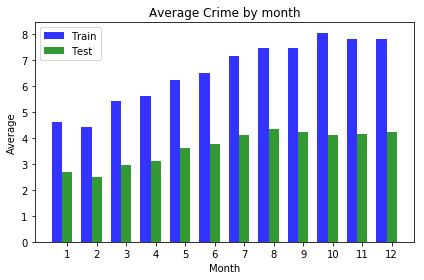

In [34]:
fig, ax = plt.subplots()
index = np.arange(12)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, merged_baseline_for_plot['Average_train'],
                 bar_width,
                 alpha=opacity,
                 color='b',
                 label='Train')
 
rects2 = plt.bar(index + bar_width, merged_baseline_for_plot['Average_test'],
                 bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test')
 
plt.xlabel('Month')
plt.ylabel('Average')
plt.title('Average Crime by month')
plt.xticks(index + bar_width, ('1',
                               '2',
                               '3',
                               '4',
                               '5',
                               '6',
                               '7',
                               '8',
                               '9',
                               '10',
                               '11',
                               '12'))
plt.legend()
 
plt.tight_layout()
plt.show()

## Linear Regression 

In [35]:
X = np.array(df_train_cp[['T_month', 'Beat', 'Primary Type']])

In [36]:
y = df_train_cp['count']

In [37]:
clf = LinearRegression().fit(X, y)
y_pred = clf.predict(np.array(df_test_cp[['T_month', 'Beat', 'Primary Type']]))
r2_score(np.array(df_test_cp['count']), y_pred)

-0.04629870544202386

In [38]:
# Trial of Multivariable Regression
X = np.array(df_train_for_average[['T_month','Beat', 'Primary Type']])

y = np.array(df_train_for_average['average'])
clf = LinearRegression().fit(X, y)
y_pred = clf.predict(np.array(df_test_for_average[['T_month','Beat', 'Primary Type']]))
r2_score(np.array(df_test_for_average['average']).reshape(-1, 1), y_pred)

-0.01584602183971273

## KNN


(80349, 3)
(80349,)
(80349, 3)
(80349,)
(80349, 3)
(80349,)
(80349, 3)
(80349,)
(80349, 3)
(80349,)
(80349, 3)
(80349,)
(80349, 3)
(80349,)
(80349, 3)
(80349,)
(80349, 3)
(80349,)


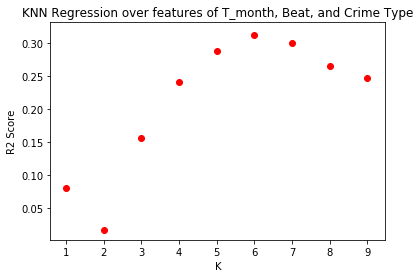

In [39]:
for x in range(1, 10):
    clf2 = KNeighborsRegressor(n_neighbors=x).fit(X, y)
    print(X.shape)
    print(y.shape)
    y_pred2 = clf2.predict(np.array(df_test_for_average[['T_month','Beat', 'Primary Type']]))
    y_ = r2_score(np.array(df_test_for_average['average']).reshape(-1, 1), y_pred2)
    plt.scatter(x, y_, color='red')
#     plt.plot(x, y_)
    plt.xlabel('K')
    plt.ylabel('R2 Score')
    plt.title('KNN Regression over features of T_month, Beat, and Crime Type')
plt.show()


In [40]:
X = df_train_for_average[['T_month','Beat','Primary Type']]
clf2 = KNeighborsRegressor(n_neighbors=6).fit(X, y)

In [41]:
y_pred2 = clf2.predict(np.array(df_test_for_average[['T_month','Beat', 'Primary Type']]))

In [42]:
r2_score(np.array(df_test_for_average['average']).reshape(-1, 1), y_pred2)

0.31280687894949055

In [43]:
## Trial on accuracy of one Beat
X = df_train_cp[['T_month','Beat','Primary Type']]
X_beat_111 = X[X['Beat'] == 134]
X_beat_111 = X_beat_111.drop('Beat', axis=1)
y_ = df_train_cp[df_train_cp['Beat'] == 134]
y_beat_111 = y_['count']
clf2 = KNeighborsRegressor(n_neighbors=13).fit(X_beat_111, y_beat_111)
y_pred2_beat = clf2.predict(np.array(df_test_cp[['T_month', 'Primary Type']]))
r2_score(np.array(df_test_cp['count']).reshape(-1, 1), y_pred2_beat)

-0.08846534977822751

In [44]:
X_beat_111.head()

,T_month,Primary Type
10878,10.0,12
17818,12.0,11
122317,7.0,6
321553,2.0,6
469429,12.0,13


In [45]:
y_beat_111.head()

10878     88
17818     11
122317     1
321553     9
469429     1
Name: count, dtype: int64

In [46]:
# Overall view on regression fit by Beat
# for i, weights in enumerate(['uniform', 'distance']):
#     X = df_train_for_average[['T_month','Beat','Primary Type']]
#     knn = KNeighborsRegressor(n_neighbors=6).fit(X, y)
#     y_ = knn.predict(np.array(df_test_for_average[['T_month', 'Beat', 'Primary Type']]))

#     plt.figure()
#     sns.barplot(list(X['Beat']), list(y), label='data', color='blue')
#     sns.barplot(np.array(df_test_for_average['Beat']), y_, label='prediction', color='red')
#     plt.axis('tight')
#     plt.legend()
#     plt.title("KNeighborsRegressor (k = 6, weights = '%s')" % (weights))

# plt.tight_layout()
# plt.show()

In [47]:
# Overall view on regression fit by Crime Type
# for i, weights in enumerate(['uniform', 'distance']):
#     X = df_train_for_average[['T_month','Beat','Primary Type']]
#     knn = KNeighborsRegressor(n_neighbors=6).fit(X, y)
#     y_ = knn.predict(np.array(df_test_for_average[['T_month', 'Beat', 'Primary Type']]))

#     plt.figure()
#     sns.barplot(np.array(df_test_for_average['Primary Type']), y_, color='red', label='prediction')
#     sns.barplot(list(X['Primary Type']), list(y), color='blue', label='data')
#     plt.axis('tight')
#     plt.legend()
#     plt.title("KNeighborsRegressor (k = 6, weights = '%s')" % (weights))

#     plt.tight_layout()
#     plt.show()

In [48]:
# Overall view on regression fit by T_month 

### THIS NEEDS TO BE FIXED ###

# for i, weights in enumerate(['uniform', 'distance']):
#     X = df_train_for_average[['T_month','Beat','Primary Type']]
#     knn = KNeighborsRegressor(n_neighbors=6).fit(X, y)
#     y_ = knn.predict(np.array(df_test_for_average[['T_month', 'Beat', 'Primary Type']]))

#     plt.figure()
#     sns.barplot(list(X['T_month']), list(y), color='blue', label='data')
#     plt.show()
#     sns.barplot(np.array(df_test_for_average['T_month']), y_, color='red', label='prediction')
#     plt.axis('tight')
#     plt.legend()
#     plt.title("KNeighborsRegressor (k = 6, weights = '%s')" % (weights))

# plt.tight_layout()
# plt.show()

In [49]:
# Overall view on regression fit by T_month SORTED OUT

# for i, weights in enumerate(['uniform', 'distance']):
#     X = df_train_for_average[['T_month','Beat','Primary Type']]
#     knn = KNeighborsRegressor(n_neighbors=6).fit(X, y)
#     y_ = knn.predict(np.array(df_test_for_average[['T_month', 'Beat', 'Primary Type']]))

#     plt.figure()
#     sns.barplot(list(X['T_month']), list(y), color='blue', label='data')
#     plt.show()
#     sns.barplot(np.array(df_test_for_average['T_month']), y_, color='red', label='prediction')
#     plt.axis('tight')
#     plt.legend()
#     plt.title("KNeighborsRegressor (k = 6, weights = '%s')" % (weights))

# plt.tight_layout()
# plt.show()

In [50]:
# Attempt on full dataset
X = df_train_cp[['T_month','Beat','Primary Type']]
y = df_train_cp['count']

for x in range(1, 15):
    print('-'*5+str(x)+'-'*5)
    clf2 = KNeighborsRegressor(n_neighbors=x).fit(X, y)
    y_pred_full = clf2.predict(np.array(df_test_cp[['T_month','Beat', 'Primary Type']]))
    y_full = r2_score(np.array(df_test_cp['count']).reshape(-1, 1), y_pred_full)
    print(y_full)
    plt.scatter(x, y_full, color='red')
#     plt.plot(x, y_full)
    plt.xlabel('K')
    plt.ylabel('R2 Score')
    plt.title('KNN Regression over features of T_month, Beat, and Crime Type')
plt.show()


-----1-----


KeyboardInterrupt: 

In [ ]:
X = df_train_cp[['T_month','Beat','Primary Type']]
y = df_train_cp['count']

clf2 = KNeighborsRegressor(n_neighbors=13).fit(X, y)
y_pred_full = clf2.predict(np.array(df_test_cp[['T_month','Beat', 'Primary Type']]))
y_full = r2_score(np.array(df_test_cp['count']).reshape(-1, 1), y_pred_full)
print(y_full)

# Decision Tree Regression

In [ ]:
from sklearn import tree
clf_tree = tree.DecisionTreeRegressor()

In [ ]:
clf_tree = clf_tree.fit(X,y)
y_pred_tree = clf_tree.predict(np.array(df_test_cp[['T_month','Beat', 'Primary Type']]))
y_tree = r2_score(np.array(df_test_cp['count']).reshape(-1, 1), y_pred_tree)

In [ ]:
print(y_tree)

In [ ]:
import graphviz

In [54]:
#Giving this a try
data = tree.export_graphviz(clf_tree, out_file=None)

In [55]:
graph = graphviz.Source(data)

In [56]:
# graph.render('chicago')
# graph

KeyboardInterrupt: 

# Creating table for Presentation

In [51]:
df_table = pd.DataFrame({'Baseline':[0.054], 'KNN Regression':[0.548], 'Linear Regression':[-0.046], 'Decision Tree':[0.544]})
df_table.head()

,Baseline,KNN Regression,Linear Regression,Decision Tree
0,0.054,0.548,-0.046,0.544


# Below are test cells and are not needed anymore

### Getting the average arrest for each crime in each beat

In [ ]:
df_grouped = df_train.groupby(['T_month', 'Primary Type', 'Beat']).mean()

In [ ]:
df_grouped_count = df.groupby(['T_month', 'Primary Type', 'Beat']).count()

In [ ]:
df_grouped_count2 = df.groupby(['Beat', 'Primary Type']).count()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
# use unstack()
ax.set_ylim(0,12000)
df_grouped_count2['ID'].unstack().plot(kind='bar', ax=ax).legend(bbox_to_anchor=(1.2, 0.5))

## Loading Chicago Shapefile

In [ ]:
gpd = geopandas.read_file('Boundaries - Police Beats (current).geojson')
gpd.plot()

In [ ]:
gpd['geometry'].head()

In [ ]:
gpd['geometry'][0]

In [ ]:
gpd.plot()

In [ ]:
print(gpd.shape)
print(len(gpd['beat_num'].unique()))

## Experiments to create full Chicago Dataframe

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy['Coordinates'].head()

In [ ]:
for place in range(277):
    for geom in gpd['geometry'][place]:
        for point in df['Coordinates']:
            if geom.contains(point):
                df['local'] = place
                if point == 1:
                    print(point)
                


In [ ]:
df['local'].head()